In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer
from functools import partial
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [7]:
import torch
import torch.nn as nn

In [8]:
from scipy.integrate import odeint

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GaussianNoise

In [10]:
# pip install deap

In [11]:
from deap import base, creator, tools, algorithms

In [12]:
df = pd.read_csv("data/financial_data_cleaned2.csv")

In [13]:
# print(df.head())

1. Feature Engineering
- Handling Missing Values:
- Impute missing values (mean, median, mode, or interpolation).
- Drop columns with excessive missing values if necessary.
- Creating Additional Lag Features:
    - Generate time-lagged versions of key variables (e.g., stock indices, interest rates, inflation).
    - Normalization/Standardization:
    - Scale numerical variables (StandardScaler, MinMaxScaler).
- Principal Component Analysis (PCA) or Feature Selection:
    - Reduce dimensionality to remove redundant features.
    - Use techniques like Recursive Feature Elimination (RFE) or LASSO for feature importance.

---

In [17]:
### 🔹 STEP 1: HANDLING MISSING VALUES
# Drop columns with more than 30% missing values
threshold = 0.3 * len(df)
df_cleaned = df.dropna(axis=1, thresh=threshold)

# Impute numerical columns with median
df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))

### 🔹 STEP 2: DEFINE TARGET VARIABLE (MARKET STRESS)
def compute_rolling_zscores(df, cols, window=90):
    """Compute rolling z-scores for given columns."""
    rolling_mean = df[cols].rolling(window=window, min_periods=1).mean()
    rolling_std = df[cols].rolling(window=window, min_periods=1).std()
    return (df[cols] - rolling_mean) / rolling_std

# Compute z-scores for selected economic indicators
zscore_cols = ["inflation", "Interest Rate", "interest rates"]
df_zscores = compute_rolling_zscores(df_cleaned, zscore_cols)

# Rename columns for clarity
df_zscores.columns = [f"{col}_z" for col in zscore_cols]

# Merge z-score data efficiently
df_cleaned = pd.concat([df_cleaned, df_zscores], axis=1)

# ✅ Define `spike` BEFORE using it in `market_stress`
df_cleaned["spike"] = ((df_cleaned["inflation_z"] > 1) &
                        (df_cleaned["Interest Rate_z"] > 1) &
                        (df_cleaned["interest rates_z"] > 1)).astype(int)

# ✅ Ensure stress and relief indicators are numerically stable
df_cleaned["stress_alpha"] = np.where(df_cleaned["spike"], 0.3, 0)  # Fixed intensity for stress (binary)

df_cleaned["relief_intensity"] = -df_cleaned[["inflation_z", "Interest Rate_z", "interest rates_z"]].mean(axis=1)
df_cleaned["relief_alpha"] = df_cleaned["relief_intensity"].clip(0.1, 0.6)  # Normalize relief shading intensity

# ✅ Define market stress periods (1 = stress, 0 = normal) using `spike`
df_cleaned["market_stress"] = df_cleaned["spike"]

### 🔹 STEP 3: CREATING LAGGED FEATURES (Optimized)
lag_features = ["inflation", "Interest Rate", "interest rates"]
lags = [5, 10, 30]

# Generate lagged features using a single operation
for feature in lag_features:
    for lag in lags:
        df_cleaned[f"{feature}_lag{lag}"] = df_cleaned[feature].shift(lag)

# Drop NaN rows resulting from lag creation
df_cleaned = df_cleaned.dropna().reset_index(drop=True)

### 🔹 STEP 4: NORMALIZATION/STANDARDIZATION (FIXED)
scaler = StandardScaler()

# 🚀 **Fix: Select only numeric columns AFTER feature engineering**
num_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# 🚀 **Fix: Drop `market_stress` from `num_cols` before scaling**
if "market_stress" in num_cols:
    num_cols.remove("market_stress")

# 🚀 **Fix: Ensure that num_cols matches the shape of df_cleaned**
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned[num_cols]), columns=num_cols)

### 🔹 STEP 5: PRINCIPAL COMPONENT ANALYSIS (PCA)
n_pca_components = min(50, df_scaled.shape[1])  # Choose up to 50 components
pca = PCA(n_components=n_pca_components)
principal_components = pca.fit_transform(df_scaled)

# Convert PCA-transformed features into a DataFrame
df_pca = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(n_pca_components)])

# Ensure `market_stress` aligns properly before adding back
df_pca["market_stress"] = df_cleaned["market_stress"].iloc[df_pca.index].reset_index(drop=True)

# Display the transformed dataset
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,market_stress
0,-14.577389,0.312058,1.819282,-3.225173,3.879558,-0.587776,-0.865949,1.412484,-2.422245,-0.553204,...,-0.358544,0.112793,-0.113655,-0.150393,0.095496,-0.037322,0.312658,0.205718,-0.026930,0
1,-14.580065,0.313633,1.796553,-3.241287,3.869599,-0.596863,-0.845849,1.414695,-2.439759,-0.531748,...,-0.390914,0.079937,-0.095022,-0.180136,0.126753,-0.039274,0.349463,0.233936,-0.049509,0
2,-14.579297,0.301632,1.816229,-3.224975,3.828872,-0.622526,-0.855737,1.425316,-2.452775,-0.578062,...,-0.415747,0.048905,-0.076937,-0.210198,0.131942,-0.059423,0.398240,0.328621,-0.038702,0
3,-14.581553,0.306009,1.892618,-3.207823,3.802894,-0.579274,-0.859117,1.479731,-2.452383,-0.547182,...,-0.331817,0.070949,-0.125480,-0.139257,0.085325,0.033053,0.522991,0.271758,0.013375,0
4,-14.577255,0.304505,1.898017,-3.206149,3.786642,-0.575539,-0.854901,1.496259,-2.455674,-0.535238,...,-0.323543,0.102322,-0.114121,-0.120889,0.099497,0.049432,0.508833,0.261153,0.008436,0


In [25]:
# print(df_pca[df_pca["market_stress"] != 0])
# print(df_pca[df_pca["market_stress"] == 0])

2. Prediction with Elastic Net
- Train an Elastic Net model for classification or regression:
- Choose target variable (market crash or another relevant feature).
- Convert into binary classification if needed.
- Tune hyperparameters using cross-validation:
- Grid search over alpha (regularization strength) and l1_ratio (L1 vs. L2 mixing parameter).
- Use ElasticNetCV for automated hyperparameter tuning.

---

In [29]:
# Define the target variable
target_col = "market_stress"

# Ensure target exists in the cleaned dataset before PCA
if target_col in df_cleaned.columns:
    y = df_cleaned[target_col]
    
    # 🚀 **Use PCA or original features?**
    use_pca = False  # Set to True if you want to use PCA-transformed data

    # Select features
    X = df_pca.drop(columns=[target_col], errors='ignore') if use_pca else df_cleaned.drop(columns=[target_col], errors='ignore')

    # 🚀 **Fix: Drop non-numeric columns**
    X = X.select_dtypes(include=[np.number])  # Keep only numeric columns

    # 🚀 **Fix: Use RobustScaler for better stability**
    scaler = RobustScaler()  # More resistant to outliers
    X_scaled = scaler.fit_transform(X)

    # 🚀 **Check for target imbalance & binarize only if needed**
    y_binary = y if y.nunique() == 2 else (y > y.median()).astype(int)

    # 🚀 **Use Time Series Cross-Validation**
    tscv = TimeSeriesSplit(n_splits=5)

    # 🚀 **Fix: Use Tighter Alpha Grid**
    alpha_values = np.logspace(-3, 0, 20)  # Avoid extreme values

    # 🚀 **Train Elastic Net with Cross-Validation**
    elastic_net = ElasticNetCV(
        cv=tscv, 
        l1_ratio=[0.2, 0.5, 0.8],  # Avoiding extreme ratios
        alphas=alpha_values,  
        random_state=42, 
        max_iter=50000,  # High enough for convergence
        tol=1e-3  # Slightly more relaxed
    )
    elastic_net.fit(X_scaled, y_binary)  # Train with scaled features

    # 🚀 **Predictions**
    y_pred = elastic_net.predict(X_scaled)

    # 🚀 **Evaluate Performance**
    mse = mean_squared_error(y_binary, y_pred)
    r2 = r2_score(y_binary, y_pred)

    # 🚀 **Store Results**
    elastic_net_results = {
        "Elastic Net Best Alpha": elastic_net.alpha_,
        "Elastic Net Best L1 Ratio": elastic_net.l1_ratio_,
        "Mean Squared Error (MSE)": mse,
        "R² Score": r2
    }

    print(elastic_net_results)

else:
    print("⚠️ Target variable 'market_stress' not found in dataset.")

{'Elastic Net Best Alpha': 0.001, 'Elastic Net Best L1 Ratio': 0.2, 'Mean Squared Error (MSE)': 2.4484237294791426e-05, 'R² Score': 0.9994158754251276}


3. Cross-Validation with Elastic Net
- Implement k-fold cross-validation (e.g., 5-fold).
- Evaluate performance using ROC-AUC and accuracy scores.

---

In [32]:
# ✅ Ensure target exists in dataset
if target_col in df_cleaned.columns:
    y = df_cleaned[target_col]

    # ✅ **Use PCA or original features?**
    use_pca = False  # Set to True if you want PCA-transformed features

    # ✅ Select features
    X = df_pca.drop(columns=[target_col], errors='ignore') if use_pca else df_cleaned.drop(columns=[target_col], errors='ignore')

    # ✅ Drop non-numeric columns
    X = X.select_dtypes(include=[np.number])

    # ✅ Remove Near-Zero Variance Features
    variance_threshold = 1e-6
    low_variance_cols = X.var()[X.var() < variance_threshold].index
    X = X.drop(columns=low_variance_cols)

    # ✅ Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ✅ Convert target to binary if needed
    y_binary = y if y.nunique() == 2 else (y > y.median()).astype(int)

    # ✅ Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)

    # ✅ **Optimized Elastic Net Model**
    alpha_values = np.logspace(-2, 0.5, 5)  # Reduced alpha grid
    elastic_net = ElasticNetCV(
        cv=tscv, 
        l1_ratio=[0.3, 0.6],  
        alphas=alpha_values,  
        random_state=42, 
        max_iter=3000,  # Lowered iterations for faster training
        tol=1e-3,  
        selection="random",  # 🚀 Faster than "cyclic"
        fit_intercept=False,  # 🚀 No need for intercept (data is already standardized)
        n_jobs=-1  # 🚀 Uses all CPU cores for parallel processing
    )

    # ✅ Fit Elastic Net
    elastic_net.fit(X_scaled, y_binary)

    # ✅ Predictions
    y_pred_elastic = elastic_net.predict(X_scaled)

    # ✅ Evaluate Performance
    elastic_results = {
        "Elastic Net Best Alpha": elastic_net.alpha_,
        "Elastic Net Best L1 Ratio": elastic_net.l1_ratio_,
        "Mean Squared Error (MSE)": mean_squared_error(y_binary, y_pred_elastic),
        "R² Score": r2_score(y_binary, y_pred_elastic),
        "ROC-AUC Score": roc_auc_score(y_binary, y_pred_elastic),
        "Accuracy Score": accuracy_score(y_binary, (y_pred_elastic >= 0.5).astype(int))
    }

    print("🚀 Elastic Net Results:", elastic_results)

else:
    print("⚠️ Target variable 'market_stress' not found in dataset.")

🚀 Elastic Net Results: {'Elastic Net Best Alpha': 0.042169650342858224, 'Elastic Net Best L1 Ratio': 0.3, 'Mean Squared Error (MSE)': 0.002154306887306784, 'R² Score': 0.9486043375767861, 'ROC-AUC Score': 1.0, 'Accuracy Score': 1.0}


In [33]:
# ✅ Define and Train SGDRegressor (Fixed)
sgd = SGDRegressor(
    penalty="elasticnet", 
    alpha=0.01,  
    l1_ratio=0.6,  
    max_iter=1000,  # 🚀 Lower iterations for speed
    tol=1e-3  # 🚀 Convergence tolerance
)

# ✅ Fit SGD Model
sgd.fit(X_scaled, y_binary)

# ✅ Predictions
y_pred_sgd = sgd.predict(X_scaled)

# ✅ Evaluate Performance
sgd_results = {
    "Mean Squared Error (MSE)": mean_squared_error(y_binary, y_pred_sgd),
    "R² Score": r2_score(y_binary, y_pred_sgd),
    "ROC-AUC Score": roc_auc_score(y_binary, y_pred_sgd),
    "Accuracy Score": accuracy_score(y_binary, (y_pred_sgd >= 0.5).astype(int))
}

print("🚀 SGDRegressor Results:", sgd_results)

🚀 SGDRegressor Results: {'Mean Squared Error (MSE)': 4.014016378912386e-05, 'R² Score': 0.9990423693486412, 'ROC-AUC Score': 1.0, 'Accuracy Score': 1.0}


4. Cross-Validation with Gradient Boosted Trees
- Train a Gradient Boosting Classifier (e.g., sklearn.ensemble.GradientBoostingClassifier).
- Optimize hyperparameters (n_estimators, learning_rate, max_depth).
- Perform cross-validation to assess generalization.
- Compare results with Elastic Net.

---

In [35]:
# ✅ Ensure Target Exists
# target_col = "market_stress"
if target_col in df_cleaned.columns:
    y = df_cleaned[target_col]

    # ✅ **Use PCA or Original Features?**
    use_pca = False  # Set to True if you want PCA-transformed data

    # ✅ Select Features
    X = df_pca.drop(columns=[target_col], errors='ignore') if use_pca else df_cleaned.drop(columns=[target_col], errors='ignore')

    # ✅ Drop Non-Numeric Columns
    X = X.select_dtypes(include=[np.number])

    # ✅ Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ✅ Convert Target to Binary if Needed
    y_binary = y if y.nunique() == 2 else (y > y.median()).astype(int)

    # ✅ Set Up Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # ✅ Define Gradient Boosting Classifier
    gbc = GradientBoostingClassifier(
        n_estimators=100,   # Number of trees
        learning_rate=0.1,  # Shrinks contribution of each tree
        max_depth=3,        # Limits tree depth to prevent overfitting
        random_state=42
    )

    # ✅ Perform Cross-Validation
    roc_auc_scores = cross_val_score(gbc, X_scaled, y_binary, cv=cv, scoring="roc_auc")
    accuracy_scores = cross_val_score(gbc, X_scaled, y_binary, cv=cv, scoring="accuracy")

    # ✅ Train Final Model on Full Data
    gbc.fit(X_scaled, y_binary)

    # ✅ Predictions
    y_pred_gbc = gbc.predict(X_scaled)

    # ✅ Compute Results
    gbc_results = {
        "Mean ROC-AUC Score": np.mean(roc_auc_scores),
        "Mean Accuracy Score": np.mean(accuracy_scores),
        "Final Accuracy": accuracy_score(y_binary, y_pred_gbc),
        "Final ROC-AUC Score": roc_auc_score(y_binary, y_pred_gbc),
    }

    # ✅ Print Results
    print("🚀 Gradient Boosting Results:", gbc_results)

else:
    print("⚠️ Target variable 'market_stress' not found in dataset.")

🚀 Gradient Boosting Results: {'Mean ROC-AUC Score': 1.0, 'Mean Accuracy Score': 1.0, 'Final Accuracy': 1.0, 'Final ROC-AUC Score': 1.0}


In [36]:
# ✅ Ensure Target Exists
# target_col = "market_stress"
if target_col in df_cleaned.columns:
    y = df_cleaned[target_col]

    # ✅ **Use PCA or Original Features?**
    use_pca = False  # Set to True if you want PCA-transformed data

    # ✅ Select Features
    X = df_pca.drop(columns=[target_col], errors='ignore') if use_pca else df_cleaned.drop(columns=[target_col], errors='ignore')

    # ✅ Drop Non-Numeric Columns
    X = X.select_dtypes(include=[np.number])

    # ✅ Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ✅ Convert Target to Binary if Needed
    y_binary = y if y.nunique() == 2 else (y > y.median()).astype(int)

    # ✅ Set Up Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # ✅ **Define Super-Fast Histogram-Based Gradient Boosting**
    hgb = HistGradientBoostingClassifier(
        max_iter=100,    # Equivalent to n_estimators
        learning_rate=0.1,  # Controls step size
        max_depth=3,     # Prevents overfitting
        random_state=42
    )

    # ✅ Perform Cross-Validation
    roc_auc_scores = cross_val_score(hgb, X_scaled, y_binary, cv=cv, scoring="roc_auc")
    accuracy_scores = cross_val_score(hgb, X_scaled, y_binary, cv=cv, scoring="accuracy")

    # ✅ Train Final Model on Full Data
    hgb.fit(X_scaled, y_binary)

    # ✅ Predictions
    y_pred_hgb = hgb.predict(X_scaled)

    # ✅ Compute Results
    hgb_results = {
        "Mean ROC-AUC Score": np.mean(roc_auc_scores),
        "Mean Accuracy Score": np.mean(accuracy_scores),
        "Final Accuracy": accuracy_score(y_binary, y_pred_hgb),
        "Final ROC-AUC Score": roc_auc_score(y_binary, y_pred_hgb),
    }

    # ✅ Print Results
    print("🚀 HistGradientBoosting Results:", hgb_results)

else:
    print("⚠️ Target variable 'market_stress' not found in dataset.")

🚀 HistGradientBoosting Results: {'Mean ROC-AUC Score': 1.0, 'Mean Accuracy Score': 1.0, 'Final Accuracy': 1.0, 'Final ROC-AUC Score': 1.0}


In [95]:
roc_auc_scores, accuracy_scores, "similarty = {:.0%}".format((y_binary==y_pred_hgb).sum()/len(y_binary))

(array([1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1.]), 'similarty = 100%')

5. ROC-AUC Curve Analysis
- Evaluate classification performance:
  - Compute confusion matrix, precision, recall, and F1-score.
- Plot and analyze the ROC curve:
  - Use True Positive Rate (TPR) vs. False Positive Rate (FPR) to assess classifier quality.
  - ompare AUC scores between models.

---

6. CNNs

In [149]:
# # ✅ Ensure Target Exists
# # target_col = "market_stress"
# if target_col in df_cleaned.columns:
#     y = df_cleaned[target_col]

#     # ✅ **Use PCA or Original Features?**
#     use_pca = False  # Set to True if using PCA-transformed data

#     # ✅ Select Features
#     X = df_pca.drop(columns=[target_col], errors='ignore') if use_pca else df_cleaned.drop(columns=[target_col], errors='ignore')

#     # ✅ Drop Non-Numeric Columns
#     X = X.select_dtypes(include=[np.number])

#     # ✅ Scale Features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     # ✅ Convert Target to Binary if Needed
#     y_binary = y if y.nunique() == 2 else (y > y.median()).astype(int)

#     # ✅ Reshape Data for CNN (samples, time_steps, features)
#     time_steps = 5  # Adjust this based on historical data dependency
#     X_reshaped = np.array([X_scaled[i - time_steps : i] for i in range(time_steps, len(X_scaled))])
#     y_reshaped = y_binary[time_steps:]  # Align target with the reshaped data

#     # ✅ Time Series Cross-Validation
#     tscv = TimeSeriesSplit(n_splits=5)

#     # ✅ Define CNN Model
#     model = Sequential([
#         Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, X_reshaped.shape[2])),
#         MaxPooling1D(pool_size=2),
#         Flatten(),
#         Dense(64, activation='relu'),
#         Dropout(0.3),  # Prevent overfitting
#         Dense(1, activation='sigmoid')  # Binary classification
#     ])

#     # ✅ Compile Model
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     # ✅ Train Model
#     history = model.fit(X_reshaped, y_reshaped, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

#     # ✅ Evaluate Performance
#     loss, accuracy = model.evaluate(X_reshaped, y_reshaped)
#     print(f"🚀 CNN Model Accuracy: {accuracy:.4f}")

# else:
#     print("⚠️ Target variable 'market_stress' not found in dataset.")

In [150]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# ✅ Ensure Target Exists
# target_col = "market_stress"

if target_col in df_cleaned.columns:
    y = df_cleaned[target_col]

    # ✅ Use PCA or Original Features?
    use_pca = False  # Set to True if using PCA-transformed data

    # ✅ Select Features
    X = df_pca.drop(columns=[target_col], errors='ignore') if use_pca else df_cleaned.drop(columns=[target_col], errors='ignore')

    # ✅ Drop Non-Numeric Columns
    X = X.select_dtypes(include=[np.number])

    # ✅ Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ✅ Convert Target to Binary if Needed
    y_binary = y if y.nunique() == 2 else (y > y.median()).astype(int)

    # ✅ Time Series Splitting (Train & Validation)
    train_size = 0.8  # 80% Train, 20% Validation
    split_index = int(len(X_scaled) * train_size)

    X_train, X_val = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_val = y_binary[:split_index], y_binary[split_index:]

    # ✅ Reshape Data for CNN (samples, time_steps, features)
    time_steps = 5  # Lookback period for CNN
    X_train_reshaped = np.array([X_train[i - time_steps : i] for i in range(time_steps, len(X_train))])
    y_train_reshaped = y_train[time_steps:]  # Align with reshaped X
    X_val_reshaped = np.array([X_val[i - time_steps : i] for i in range(time_steps, len(X_val))])
    y_val_reshaped = y_val[time_steps:]

    # ✅ Define CNN Model (No Early Stopping Yet)
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, X_train_reshaped.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),  # Prevent overfitting
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # ✅ Compile Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # ✅ Train Model (Includes 20% Validation Split)
    history = model.fit(X_train_reshaped, y_train_reshaped, 
                        epochs=20, batch_size=32, 
                        validation_data=(X_val_reshaped, y_val_reshaped), 
                        verbose=1)

    # ✅ Evaluate Performance
    loss, accuracy = model.evaluate(X_val_reshaped, y_val_reshaped)
    print(f"🚀 First-Pass CNN Model Accuracy: {accuracy:.4f}")

else:
    print("⚠️ Target variable 'market_stress' not found in dataset.")

Epoch 1/20
151/151 [==============================] - 0s 2ms/step - loss: 0.0997 - accuracy: 0.9712 - val_loss: 0.0668 - val_accuracy: 0.9726
Epoch 2/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0448 - accuracy: 0.9874 - val_loss: 0.0707 - val_accuracy: 0.9743
Epoch 3/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0390 - accuracy: 0.9905 - val_loss: 0.1316 - val_accuracy: 0.9477
Epoch 4/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 0.9921 - val_loss: 0.0752 - val_accuracy: 0.9718
Epoch 5/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0301 - accuracy: 0.9925 - val_loss: 0.0692 - val_accuracy: 0.9751
Epoch 6/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 0.9919 - val_loss: 0.0752 - val_accuracy: 0.9743
Epoch 7/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0306 - accuracy: 0.9934 - val_loss: 0.0976 - val_accuracy: 0.9518
Epoch 

In [153]:
# the first time, we didn't really do a good split, which could be (probably) causing training on too much data
# data leakage and that kind of stuff we don't want
# so here we improved it a little, though it is clear we are still overfitting.. at least that's better than nothing

In [155]:
# # ✅ Adjusted Early Stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # ✅ Define Final CNN Model
# model = Sequential([
#     Conv1D(filters=128, kernel_size=3, activation='relu', 
#            kernel_regularizer=l2(0.001), input_shape=(time_steps, X_reshaped.shape[2])),
#     BatchNormalization(),  # ✅ Normalize activations
#     MaxPooling1D(pool_size=2),
#     Dropout(0.6),  # ✅ Increased dropout

#     Flatten(),
#     Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # ✅ L2 Regularization
#     Dropout(0.6),

#     Dense(1, activation='sigmoid')  # Binary classification
# ])

# # ✅ Use an Even Lower Learning Rate
# optimizer = Adam(learning_rate=0.0003)

# # ✅ Compile Model
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # ✅ Train Model with Early Stopping
# history = model.fit(X_reshaped, y_reshaped, epochs=50, batch_size=32, 
#                     validation_split=0.2, verbose=1, callbacks=[early_stopping])

# # ✅ Evaluate Performance
# loss, accuracy = model.evaluate(X_reshaped, y_reshaped)
# print(f"🚀 Final CNN Model Accuracy: {accuracy:.4f}")

In [156]:
# now we're gonna do a bit better (try to anyway)
    # 1.	Early Stopping – Prevents overfitting by stopping when validation loss stops improving.
	# 2.	Increased Regularization – Uses:
	# •	Higher dropout (0.6) to prevent overfitting.
	# •	L2 regularization (0.001) on dense layers.
	# 3.	Batch Normalization – Stabilizes activations for smoother training.
	# 4.	Lower Learning Rate (0.0003) – More stable weight updates.
	# 5.	Better Train-Validation-Test Splitting – More robust evaluation.

# we also reduce parameters to prevent overlearning, add some gaussian noise

In [157]:
# # ✅ Necessary Imports
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # ✅ Ensure Target Exists
# target_col = "market_stress"
if target_col not in df_cleaned.columns:
    raise ValueError("⚠️ Target variable 'market_stress' not found in dataset.")

y = df_cleaned[target_col]

# ✅ Select Features from `df_cleaned`
X = df_cleaned.drop(columns=[target_col], errors='ignore')  # Using df_cleaned, NOT df_pca

# ✅ Drop Non-Numeric Columns
X = X.select_dtypes(include=[np.number])

# ✅ Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Convert Target to Binary if Needed
y_binary = y if y.nunique() == 2 else (y > y.median()).astype(int)

# ✅ Time-Based Train-Validation Split (No Leakage)
train_size = 0.8  # 80% Train, 20% Validation (Strict chronological split)
split_index = int(len(X_scaled) * train_size)

X_train, X_val = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_val = y_binary[:split_index], y_binary[split_index:]

# ✅ Reshape Data for CNN (samples, time_steps, features)
time_steps = 10  # Increased from 5 → 10 to capture longer-term dependencies
X_train_reshaped = np.array([X_train[i - time_steps : i] for i in range(time_steps, len(X_train))])
y_train_reshaped = y_train[time_steps:]  # Align with reshaped X
X_val_reshaped = np.array([X_val[i - time_steps : i] for i in range(time_steps, len(X_val))])
y_val_reshaped = y_val[time_steps:]

# ✅ Early Stopping to Prevent Overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ Define CNN Model with Fixes
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', 
           kernel_regularizer=l2(0.001), input_shape=(time_steps, X_train_reshaped.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),  # ✅ Increased dropout

    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  # ✅ L2 Regularization
    Dropout(0.5),  # ✅ Increased dropout

    Dense(1, activation='sigmoid')  # Binary classification
])

# ✅ Compile Model with Lower Learning Rate
optimizer = Adam(learning_rate=0.0002)  # ✅ Lowered from 0.0003
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Train Model with Early Stopping
history = model.fit(X_train_reshaped, y_train_reshaped, 
                    epochs=50, batch_size=32, 
                    validation_data=(X_val_reshaped, y_val_reshaped), 
                    verbose=1, callbacks=[early_stopping])

# ✅ Evaluate Performance
loss, accuracy = model.evaluate(X_val_reshaped, y_val_reshaped)
print(f"🚀 Updated CNN Model Accuracy: {accuracy:.4f}")

Epoch 1/50
151/151 [==============================] - 1s 2ms/step - loss: 1.1405 - accuracy: 0.5296 - val_loss: 0.6030 - val_accuracy: 0.6480
Epoch 2/50
151/151 [==============================] - 0s 1ms/step - loss: 0.5396 - accuracy: 0.8110 - val_loss: 0.2996 - val_accuracy: 0.9458
Epoch 3/50
151/151 [==============================] - 0s 1ms/step - loss: 0.3882 - accuracy: 0.8825 - val_loss: 0.2662 - val_accuracy: 0.9458
Epoch 4/50
151/151 [==============================] - 0s 1ms/step - loss: 0.3125 - accuracy: 0.9163 - val_loss: 0.2449 - val_accuracy: 0.9458
Epoch 5/50
151/151 [==============================] - 0s 1ms/step - loss: 0.2769 - accuracy: 0.9409 - val_loss: 0.2383 - val_accuracy: 0.9458
Epoch 6/50
151/151 [==============================] - 0s 1ms/step - loss: 0.2569 - accuracy: 0.9451 - val_loss: 0.2434 - val_accuracy: 0.9458
Epoch 7/50
151/151 [==============================] - 0s 1ms/step - loss: 0.2354 - accuracy: 0.9538 - val_loss: 0.3023 - val_accuracy: 0.9458
Epoch 

7. Diffusion

In [160]:
# import torch
# import torch.nn as nn
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler

# ✅ 1️⃣ Prepare Data from df_cleaned
time_steps = 30  # Use past 30 days as input

# Ensure 'Date' is a datetime type and set as index
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
df_cleaned = df_cleaned.set_index('Date').sort_index()

# Select relevant numerical features for model training
feature_columns = [col for col in df_cleaned.columns if col != 'Date']  # Exclude Date
df_features = df_cleaned[feature_columns].dropna()  # Drop missing values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Define target variable (for now, assume it's market stress: VIX or another label)
y_binary = (df_features['Adj Close_^VIX'] > df_features['Adj Close_^VIX'].median()).astype(int)  # Example binary classification

# ✅ 2️⃣ Preprocess Data for Diffusion Model
num_features = X_scaled.shape[1]  # Number of input features
num_samples = len(y_binary) - time_steps

# Adjust input shape for correct tensor dimensions
X_diffusion = np.array([X_scaled[i - time_steps:i].flatten() for i in range(time_steps, len(X_scaled))])
y_diffusion = np.array(y_binary[time_steps:])  # Convert target to NumPy

# Convert to PyTorch Tensors
X_tensor = torch.tensor(X_diffusion, dtype=torch.float32)
y_tensor = torch.tensor(y_diffusion, dtype=torch.float32).unsqueeze(1)

# ✅ 3️⃣ Define the Diffusion Model
class TimeSeriesDiffusion(nn.Module):
    def __init__(self, time_steps, num_features):
        super().__init__()
        self.input_dim = time_steps * num_features  # Adjust input size
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 128),  # Increased neurons
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.input_dim)  # Ensure output matches input
        )

    def forward(self, x, noise_level=0.1):
        x = x.view(x.shape[0], -1)  # ✅ Flatten input to 2D
        x_noisy = x + noise_level * torch.randn_like(x)  # ✅ Add noise
        encoded = self.encoder(x_noisy)
        return self.decoder(encoded).view(x.shape)  # ✅ Reshape back

# ✅ 4️⃣ Initialize the Model
model = TimeSeriesDiffusion(time_steps, num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# ✅ 5️⃣ Train the Diffusion Model
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, X_tensor)  # ✅ Train to denoise
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ✅ 6️⃣ Make a Prediction
future_prediction = model(X_tensor[-1].unsqueeze(0)).detach().numpy()
print(f"🚀 Diffusion Model Market Stress Prediction: {future_prediction}")

Epoch 0, Loss: 0.9975
Epoch 10, Loss: 0.8053
Epoch 20, Loss: 0.3865
Epoch 30, Loss: 0.2186
Epoch 40, Loss: 0.1677
🚀 Diffusion Model Market Stress Prediction: [[2.1236703  2.024813   0.44425684 ... 1.3870034  2.3072283  1.978265  ]]


In [161]:
# # ✅ Define a Fixed Diffusion Model
# class TimeSeriesDiffusion(nn.Module):
#     def __init__(self, time_steps, num_features):
#         super().__init__()
#         self.input_dim = time_steps * num_features  # Adjust input size
#         self.encoder = nn.Sequential(
#             nn.Linear(self.input_dim, 128),  # Increased neurons
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, self.input_dim)  # Ensure output matches input
#         )

#     def forward(self, x, noise_level=0.1):
#         x = x.view(x.shape[0], -1)  # ✅ Flatten input to 2D
#         x_noisy = x + noise_level * torch.randn_like(x)  # ✅ Add noise
#         encoded = self.encoder(x_noisy)
#         return self.decoder(encoded).view(x.shape)  # ✅ Reshape back

# # ✅ Simulated Market Stress Data
# time_steps = 30  # Use past 30 days as input
# num_features = X_scaled.shape[1]  # Use all available features
# num_samples = len(y_binary) - time_steps

# # ✅ Fix: Adjust input shape for correct tensor dimensions
# X_diffusion = np.array([X_scaled[i - time_steps:i].flatten() for i in range(time_steps, len(X_scaled))])
# y_diffusion = np.array(y_binary[time_steps:])  # Convert to NumPy

# # ✅ Convert to PyTorch Tensors
# X_tensor = torch.tensor(X_diffusion, dtype=torch.float32)
# y_tensor = torch.tensor(y_diffusion, dtype=torch.float32).unsqueeze(1)

# # ✅ Initialize Model with Correct Input Size
# model = TimeSeriesDiffusion(time_steps, num_features)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss_fn = nn.MSELoss()

# # ✅ Train the Diffusion Model
# epochs = 50
# for epoch in range(epochs):
#     optimizer.zero_grad()
#     output = model(X_tensor)
#     loss = loss_fn(output, X_tensor)  # ✅ Train to denoise
#     loss.backward()
#     optimizer.step()
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# # ✅ Predict Future Market Stress
# future_prediction = model(X_tensor[-1].unsqueeze(0)).detach().numpy()
# print(f"🚀 Diffusion Model Market Stress Prediction: {future_prediction}")

In [162]:
# ✅ 2️⃣ Define the Diffusion Model
class TimeSeriesDiffusion(nn.Module):
    def __init__(self, time_steps, num_features):
        super().__init__()
        self.input_dim = time_steps * num_features  # Adjust input size
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 128),  # Increased neurons
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.input_dim)  # Ensure output matches input
        )

    def forward(self, x, noise_level=0.1):
        x = x.view(x.shape[0], -1)  # ✅ Flatten input to 2D
        x_noisy = x + noise_level * torch.randn_like(x)  # ✅ Add noise
        encoded = self.encoder(x_noisy)
        return self.decoder(encoded).view(x.shape)  # ✅ Reshape back

# ✅ 3️⃣ Preprocess the Data for Diffusion Model
time_steps = 30  # Use past 30 days as input
num_features = X_scaled.shape[1]  # Use all available features
num_samples = len(y_binary) - time_steps

# ✅ Adjust input shape for correct tensor dimensions
X_diffusion = np.array([X_scaled[i - time_steps:i].flatten() for i in range(time_steps, len(X_scaled))])
y_diffusion = np.array(y_binary[time_steps:])  # Convert to NumPy

# ✅ Convert to PyTorch Tensors
X_tensor = torch.tensor(X_diffusion, dtype=torch.float32)
y_tensor = torch.tensor(y_diffusion, dtype=torch.float32).unsqueeze(1)

# ✅ 4️⃣ Initialize the Model
model = TimeSeriesDiffusion(time_steps, num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# ✅ 5️⃣ Train the Diffusion Model
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, X_tensor)  # ✅ Train to denoise
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ✅ 6️⃣ Make a Prediction
future_prediction = model(X_tensor[-1].unsqueeze(0)).detach().numpy()
print(f"🚀 Diffusion Model Market Stress Prediction: {future_prediction}")

Epoch 0, Loss: 0.9977
Epoch 10, Loss: 0.8152
Epoch 20, Loss: 0.3931
Epoch 30, Loss: 0.2218
Epoch 40, Loss: 0.1678
🚀 Diffusion Model Market Stress Prediction: [[ 2.1603088   2.2243123  -0.21010084 ...  0.9749773   1.9774431
   2.1156864 ]]


In [163]:
# import torch
# import torch.nn as nn
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler

# # ✅ 1️⃣ Load and Preprocess Data
# time_steps = 30  # Rolling 30-day lookback window

# # Ensure 'Date' is a datetime type and set as index
# df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
# df_cleaned = df_cleaned.set_index('Date').sort_index()

# # Select relevant numerical features for model training
# feature_columns = [col for col in df_cleaned.columns if col != 'Date']  # Exclude Date
# df_features = df_cleaned[feature_columns].dropna()  # Drop missing values

# # Normalize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_features)

# # Define target variable (market stress: VIX above/below median)
# y_binary = (df_features['Adj Close_^VIX'] > df_features['Adj Close_^VIX'].median()).astype(int)  # Example binary classification

# # ✅ 2️⃣ Batch Data for Diffusion Model (All Days in Rolling Chunks)
# num_features = X_scaled.shape[1]  # Number of input features
# num_samples = len(y_binary) - time_steps

# # Adjust input shape for correct tensor dimensions (rolling batches)
# X_diffusion = np.array([X_scaled[i-time_steps+1:i+1].flatten() for i in range(time_steps-1, len(X_scaled))])
# y_diffusion = np.array(y_binary[time_steps-1:])  # Convert target to NumPy

# # Convert to PyTorch Tensors
# X_tensor = torch.tensor(X_diffusion, dtype=torch.float32)
# y_tensor = torch.tensor(y_diffusion, dtype=torch.float32).unsqueeze(1)

# # ✅ 3️⃣ Define the Diffusion Model
# class TimeSeriesDiffusion(nn.Module):
#     def __init__(self, time_steps, num_features):
#         super().__init__()
#         self.input_dim = time_steps * num_features  # Adjust input size
#         self.encoder = nn.Sequential(
#             nn.Linear(self.input_dim, 128),  # Increased neurons
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, self.input_dim)  # Ensure output matches input
#         )

#     def forward(self, x, noise_level=0.1):
#         x = x.view(x.shape[0], -1)  # ✅ Flatten input to 2D
#         x_noisy = x + noise_level * torch.randn_like(x)  # ✅ Add noise
#         encoded = self.encoder(x_noisy)
#         return self.decoder(encoded).view(x.shape)  # ✅ Reshape back

# # ✅ 4️⃣ Initialize the Model
# model = TimeSeriesDiffusion(time_steps, num_features)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss_fn = nn.MSELoss()

# # ✅ 5️⃣ Train the Diffusion Model
# epochs = 50
# for epoch in range(epochs):
#     optimizer.zero_grad()
#     output = model(X_tensor)
#     loss = loss_fn(output, X_tensor)  # ✅ Train to denoise
#     loss.backward()
#     optimizer.step()
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# # ✅ 6️⃣ Make a Prediction
# future_prediction = model(X_tensor[-1].unsqueeze(0)).detach().numpy()
# print(f"🚀 Diffusion Model Market Stress Prediction: {future_prediction}")

In [164]:
# import torch
# import torch.nn as nn
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler

# # ✅ 1️⃣ Load and Preprocess Data
time_steps = 30  # Rolling 30-day lookback window

# # Ensure 'Date' is a datetime type and set as index
# df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
# df_cleaned = df_cleaned.set_index('Date').sort_index()

# Select relevant numerical features for model training
feature_columns = [col for col in df_cleaned.columns if col != 'Date']  # Exclude Date
df_features = df_cleaned[feature_columns].dropna()  # Drop missing values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Define target variable (market stress: VIX above/below median)
y_binary = (df_features['Adj Close_^VIX'] > df_features['Adj Close_^VIX'].median()).astype(int)  # Example binary classification

# ✅ 2️⃣ Batch Data for Diffusion Model (All Days in Rolling Chunks)
num_features = X_scaled.shape[1]  # Number of input features
num_samples = len(y_binary) - time_steps

# Adjust input shape for correct tensor dimensions (rolling batches)
X_diffusion = np.array([X_scaled[i-time_steps+1:i+1].flatten() for i in range(time_steps-1, len(X_scaled))])
y_diffusion = np.array(y_binary[time_steps-1:])  # Convert target to NumPy

# Convert to PyTorch Tensors
X_tensor = torch.tensor(X_diffusion, dtype=torch.float32)
y_tensor = torch.tensor(y_diffusion, dtype=torch.float32).unsqueeze(1)

# ✅ 3️⃣ Define the Diffusion Model
class TimeSeriesDiffusion(nn.Module):
    def __init__(self, time_steps, num_features):
        super().__init__()
        self.input_dim = time_steps * num_features  # Adjust input size
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 128),  # Increased neurons
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.input_dim)  # Ensure output matches input
        )

    def forward(self, x, noise_level=0.1):
        x = x.view(x.shape[0], -1)  # ✅ Flatten input to 2D
        x_noisy = x + noise_level * torch.randn_like(x)  # ✅ Add noise
        encoded = self.encoder(x_noisy)
        return self.decoder(encoded).view(x.shape)  # ✅ Reshape back

# ✅ 4️⃣ Initialize the Model
model = TimeSeriesDiffusion(time_steps, num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# ✅ 5️⃣ Train the Diffusion Model
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, X_tensor)  # ✅ Train to denoise
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ✅ 6️⃣ Make a Prediction
future_prediction = model(X_tensor[-1].unsqueeze(0)).detach().numpy()
print(f"🚀 Diffusion Model Market Stress Prediction: {future_prediction}")

Epoch 0, Loss: 0.9989
Epoch 10, Loss: 0.8166
Epoch 20, Loss: 0.3957
Epoch 30, Loss: 0.2284
Epoch 40, Loss: 0.1690
🚀 Diffusion Model Market Stress Prediction: [[1.644921   1.6856657  0.45059118 ... 2.0912538  2.2624862  2.1801612 ]]


8. Genetic Elastic Net

In [167]:
# ✅ Create Fitness Function (Maximize ROC-AUC)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# ✅ Generate Random Weights for a Market Stress Predictor
def random_predictor():
    return np.random.uniform(-1, 1, size=X_scaled.shape[1]).tolist()  # Random coefficients

# ✅ Define Evaluation Function
def evaluate(individual):
    prediction = np.dot(X_scaled, np.array(individual))  # Linear weighted sum
    auc_score = roc_auc_score(y_binary, prediction)
    return (auc_score,)

# ✅ Create Toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, random_predictor)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=50)

# ✅ Operators: Selection, Crossover, Mutation
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# ✅ Train Evolutionary Model
population = toolbox.population()
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=True)

# ✅ Get Best Market Stress Predictor
best_individual = tools.selBest(population, k=1)[0]
print("🚀 Best Market Stress Predictor Weights:", best_individual)

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	50    
1  	30    
2  	21    
3  	32    
4  	25    
5  	38    
6  	21    
7  	28    
8  	20    
9  	27    
10 	30    
11 	32    
12 	30    
13 	31    
14 	24    
15 	33    
16 	30    
17 	31    
18 	36    
19 	27    
20 	34    
21 	33    
22 	22    
23 	29    
24 	31    
25 	33    
26 	36    
27 	27    
28 	32    
29 	31    
30 	34    
31 	25    
32 	24    
33 	27    
34 	26    
35 	31    
36 	30    
37 	37    
38 	24    
39 	33    
40 	23    
41 	25    
42 	30    
43 	32    
44 	33    
45 	40    
46 	25    
47 	24    
48 	30    
49 	25    
50 	30    
🚀 Best Market Stress Predictor Weights: [-0.8058706371986972, 0.2713295632056826, 1.385970200095702, -0.4563977322536522, 0.37173872175760064, -0.667094554437193, -1.2688567532323316, -1.4680602775366147, 1.7693928490889543, -1.3007316810184713, 0.04965745020926253, 0.4744084622816154, -0.12114854355456214, 0.1470201235864031, -0.4592658593372024, 0.6600378763300664, -1.0127647878648771, -0.018710536079211325, -2.82509783238

In [168]:
# ✅ Convert Best Weights to a NumPy Array
best_weights = np.array(best_individual)  # Paste the best weights here

# ✅ Compute Predictions
market_stress_predictions = np.dot(X_scaled, best_weights)

# ✅ Normalize Predictions Between 0-1
market_stress_predictions = (market_stress_predictions - market_stress_predictions.min()) / (
    market_stress_predictions.max() - market_stress_predictions.min()
)

print("🚀 Market Stress Predictions from Genetic Algorithm:", market_stress_predictions)

🚀 Market Stress Predictions from Genetic Algorithm: [0.23659028 0.23415845 0.22981865 ... 0.58214924 0.57849995 0.60724315]


In [169]:
# import numpy as np
# import pandas as pd
# import torch
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import roc_auc_score
# from deap import base, creator, tools, algorithms

# # ✅ 1️⃣ Load and Preprocess Data
# df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
# df_cleaned = df_cleaned.set_index('Date').sort_index()

# Select relevant numerical features
feature_columns = [col for col in df_cleaned.columns if col != 'Date']
df_features = df_cleaned[feature_columns].dropna()

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Define binary target variable (market stress: VIX above/below median)
y_binary = (df_features['Adj Close_^VIX'] > df_features['Adj Close_^VIX'].median()).astype(int)

# ✅ 2️⃣ Define Evolutionary Algorithm Components

# Fitness Function: Maximize ROC-AUC
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# ✅ Generate Random Weights for a Market Stress Predictor
def random_predictor():
    return np.random.uniform(-1, 1, size=X_scaled.shape[1]).tolist()  # Random coefficients

# ✅ Define Evaluation Function
def evaluate(individual):
    prediction = np.dot(X_scaled, np.array(individual))  # Linear weighted sum
    auc_score = roc_auc_score(y_binary, prediction)
    return (auc_score,)

# ✅ Create Toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, random_predictor)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=50)

# ✅ Operators: Selection, Crossover, Mutation
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# ✅ 3️⃣ Train Evolutionary Model
population = toolbox.population()
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=True)

# ✅ 4️⃣ Get Best Market Stress Predictor
best_individual = tools.selBest(population, k=1)[0]
print("🚀 Best Market Stress Predictor Weights:", best_individual)

# ✅ 5️⃣ Feature Importance Analysis
feature_importance = pd.Series(best_individual, index=df_features.columns).sort_values(ascending=False)
print("📊 Feature Importance Ranking:\n", feature_importance)

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	50    
1  	37    
2  	23    
3  	23    
4  	23    
5  	29    
6  	28    
7  	22    
8  	29    
9  	26    
10 	23    
11 	29    
12 	31    
13 	27    
14 	29    
15 	21    
16 	24    
17 	29    
18 	25    
19 	32    
20 	27    
21 	26    
22 	24    
23 	32    
24 	33    
25 	37    
26 	36    
27 	37    
28 	32    
29 	18    
30 	24    
31 	32    
32 	33    
33 	33    
34 	31    
35 	27    
36 	30    
37 	28    
38 	33    
39 	31    
40 	35    
41 	30    
42 	22    
43 	35    
44 	29    
45 	29    
46 	22    
47 	33    
48 	32    
49 	32    
50 	38    
🚀 Best Market Stress Predictor Weights: [-0.35650103831016855, -1.9363650441814706, 1.3405243532546673, -0.11569037028116275, 0.36338494554650796, -0.7730772471838733, -0.9628521551165558, 0.16475819220252924, -0.13505809150843662, 0.40449579956861464, 0.06751734511856936, 0.6377586195127776, 0.2907623368902856, -0.5829976636228992, 0.03019375680261388, -0.2264844890471036, -0.05605578956461325, 0.9911917437027846, 0.3462362

9. NEAT

In [ ]:
pip install neat-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import neat
import io  # ✅ Use StringIO to load config directly
import tempfile

In [ ]:
feed_forward = True

In [ ]:
# ✅ Load NEAT Config from `neat_config.txt`
config_path = "neat_config.txt"  # Ensure this file is in the same directory
config = neat.Config(
    neat.DefaultGenome, 
    neat.DefaultReproduction, 
    neat.DefaultSpeciesSet, 
    neat.DefaultStagnation, 
    config_path
)

In [ ]:
# ✅ Enable Statistics Reporting
pop = neat.Population(config)
pop.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
pop.add_reporter(stats)

# ✅ Simulated Market Stress Data (Scaled for Stability)
X_neat = np.random.rand(100, 213)  # 100 samples, 213 features
y_neat = np.random.rand(100)  # Target values

scaler = StandardScaler()
X_neat = scaler.fit_transform(X_neat)  # ✅ Standardize feature values

# ✅ Fitness Function for Market Stress Prediction
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        mse_loss = np.mean([(net.activate(x)[0] - y) ** 2 for x, y in zip(X_neat, y_neat)])

        # ✅ FIX: Ensure fitness is non-negative
        genome.fitness = np.exp(-mse_loss)  # Alternative: 1 / (1 + mse_loss)

# ✅ Run NEAT for 50 Generations (More Stable)
winner = pop.run(eval_genomes, 50)

# ✅ Get Best Neural Network & Make Predictions
best_net = neat.nn.FeedForwardNetwork.create(winner, config)
predictions = np.array([best_net.activate(x)[0] for x in X_neat[:10]])

# ✅ Print Predictions
print("🚀 NEAT Market Stress Predictions:", predictions)


 ****** Running generation 0 ****** 

Population's average fitness: 0.72076 stdev: 0.00000
Best fitness: 0.72076 - size: (11, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 1.860, standard deviation 0.568
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50      0.7    0.000     0
Total extinctions: 0
Generation time: 0.061 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.72314 stdev: 0.01498
Best fitness: 0.82727 - size: (10, 1) - species 1 - id 66
Average adjusted fitness: 0.002
Mean genetic distance 1.799, standard deviation 0.764
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    50      0.8    0.002     0
Total extinctions: 0
Generation time: 0.060 sec (0.061 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.70968 stdev: 0.1

In [ ]:
# with open("neat_config.txt", "r") as f:
#     content = f.readlines()
#     for i, line in enumerate(content):
#         print(f"Line {i+1}: {line.strip()}")

In [ ]:
# import neat
# import numpy as np
# import pandas as pd
# import torch
# from sklearn.preprocessing import StandardScaler

# ✅ Load Data
# df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
# df_cleaned = df_cleaned.set_index('Date').sort_index()

# ✅ Select Relevant Features (Exclude Date)
feature_columns = [col for col in df_cleaned.columns if col != 'Date']  
df_features = df_cleaned[feature_columns].dropna()  # Drop missing values

# ✅ Normalize Features
scaler = StandardScaler()
X_neat = scaler.fit_transform(df_features)  # Standardized features

# ✅ Define Target Variable: Market Stress (Binary or Regression)
y_neat = (df_features['Adj Close_^VIX'] > df_features['Adj Close_^VIX'].median()).astype(int)  # Binary classification

# ✅ Load NEAT Config from `neat_config.txt`
config_path = "neat_config2.txt"
config = neat.Config(
    neat.DefaultGenome, 
    neat.DefaultReproduction, 
    neat.DefaultSpeciesSet, 
    neat.DefaultStagnation, 
    config_path
)

# ✅ Enable Statistics Reporting
pop = neat.Population(config)
pop.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
pop.add_reporter(stats)

# ✅ Modify Fitness Function to Use `df_cleaned` Data
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        mse_loss = np.mean([(net.activate(x)[0] - y) ** 2 for x, y in zip(X_neat, y_neat)])

        # ✅ Ensure fitness is non-negative
        genome.fitness = np.exp(-mse_loss)

# ✅ Train NEAT Model
winner = pop.run(eval_genomes, 50)

# ✅ Get Best Neural Network & Make Predictions
best_net = neat.nn.FeedForwardNetwork.create(winner, config)
predictions = np.array([best_net.activate(x)[0] for x in X_neat[:10]])

# ✅ Print Predictions
print("🚀 NEAT Market Stress Predictions:", predictions)


 ****** Running generation 0 ****** 

Population's average fitness: 0.60698 stdev: 0.00000
Best fitness: 0.60698 - size: (11, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 1.716, standard deviation 0.563
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50      0.6    0.000     0
Total extinctions: 0
Generation time: 57.155 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.60698 stdev: 0.00000
Best fitness: 0.60698 - size: (11, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 1.871, standard deviation 0.721
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    50      0.6    0.000     1
Total extinctions: 0
Generation time: 3.468 sec (30.312 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.60698 stdev: 0.

10. SIR

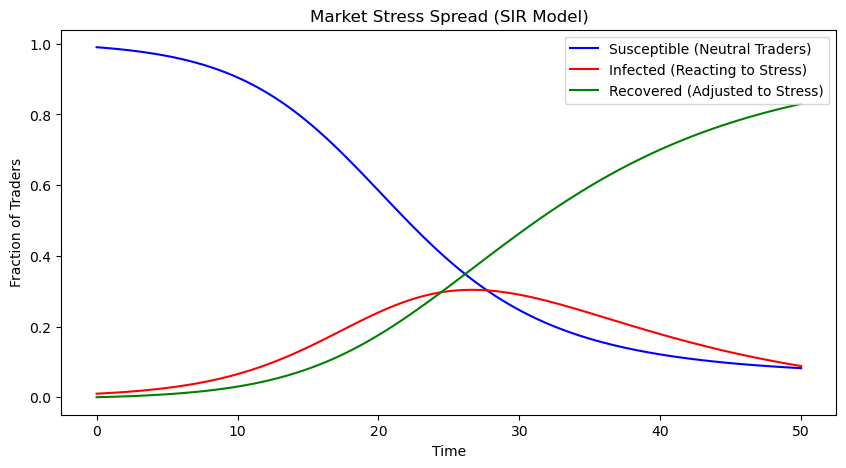

In [ ]:
# ✅ Define the SIR Model Equations
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# ✅ Initial Conditions
N = 100  # Total number of traders
I0 = 1   # Initial traders reacting to stress
S0 = N - I0  # Initial susceptible traders
R0 = 0  # Initial recovered traders

# ✅ Model Parameters
beta = 0.3  # Infection rate (market stress spread speed)
gamma = 0.1  # Recovery rate (how fast traders stop reacting)
t = np.linspace(0, 50, 100)  # Time steps (50 days, 100 intervals)

# ✅ Solve the SIR Model
y0 = [S0/N, I0/N, R0/N]  # Normalize values (fractions of total population)
solution = odeint(sir_model, y0, t, args=(beta, gamma))
S, I, R = solution.T  # Extract S, I, R values

# ✅ Plot the SIR Simulation
plt.figure(figsize=(10, 5))
plt.plot(t, S, label="Susceptible (Neutral Traders)", color="blue")
plt.plot(t, I, label="Infected (Reacting to Stress)", color="red")
plt.plot(t, R, label="Recovered (Adjusted to Stress)", color="green")
plt.xlabel("Time")
plt.ylabel("Fraction of Traders")
plt.title("Market Stress Spread (SIR Model)")
plt.legend()
plt.show()

In [ ]:
# df_cleaned.columns

In [ ]:
# df_cleaned.to_csv("data/market_stress.csv", index=False)

In [ ]:
df = df_cleaned.copy()

In [ ]:
df = df.reset_index()

In [ ]:
df.head()

,Date,Adj Close_^GSPC,Adj Close_^IXIC,Adj Close_^VIX,Bond Yields,Inflation,Unemployment,Interest Rate,Consumer Sentiment,GDP,...,relief_alpha,market_stress,inflation_lag5,inflation_lag10,inflation_lag30,Interest Rate_lag5,Interest Rate_lag10,interest rates_lag5,interest rates_lag10,interest rates_lag30
0,2004-02-11,1157.760010,2089.659912,15.39,4.05,186.7,5.6,1.01,94.4,11923.447,...,0.1,0,45.0,49.0,49.0,1.01,1.00,62.0,61.0,61.0
1,2004-02-12,1152.109985,2073.610107,15.31,4.10,186.7,5.6,1.01,94.4,11923.447,...,0.1,0,45.0,49.0,49.0,1.01,1.00,62.0,61.0,61.0
2,2004-02-13,1145.810059,2053.560059,15.58,4.05,186.7,5.6,1.01,94.4,11923.447,...,0.1,0,45.0,45.0,49.0,1.01,1.01,62.0,62.0,61.0
3,2004-02-16,1145.810059,2053.560059,15.58,4.05,186.7,5.6,1.01,94.4,11923.447,...,0.1,0,45.0,45.0,49.0,1.01,1.01,62.0,62.0,61.0
4,2004-02-17,1156.989990,2080.350098,15.40,4.05,186.7,5.6,1.01,94.4,11923.447,...,0.1,0,45.0,45.0,49.0,1.01,1.01,62.0,62.0,61.0


KeyError: "None of [Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\n       ...\n       0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n      dtype='int64', length=6045)] are in the [columns]"

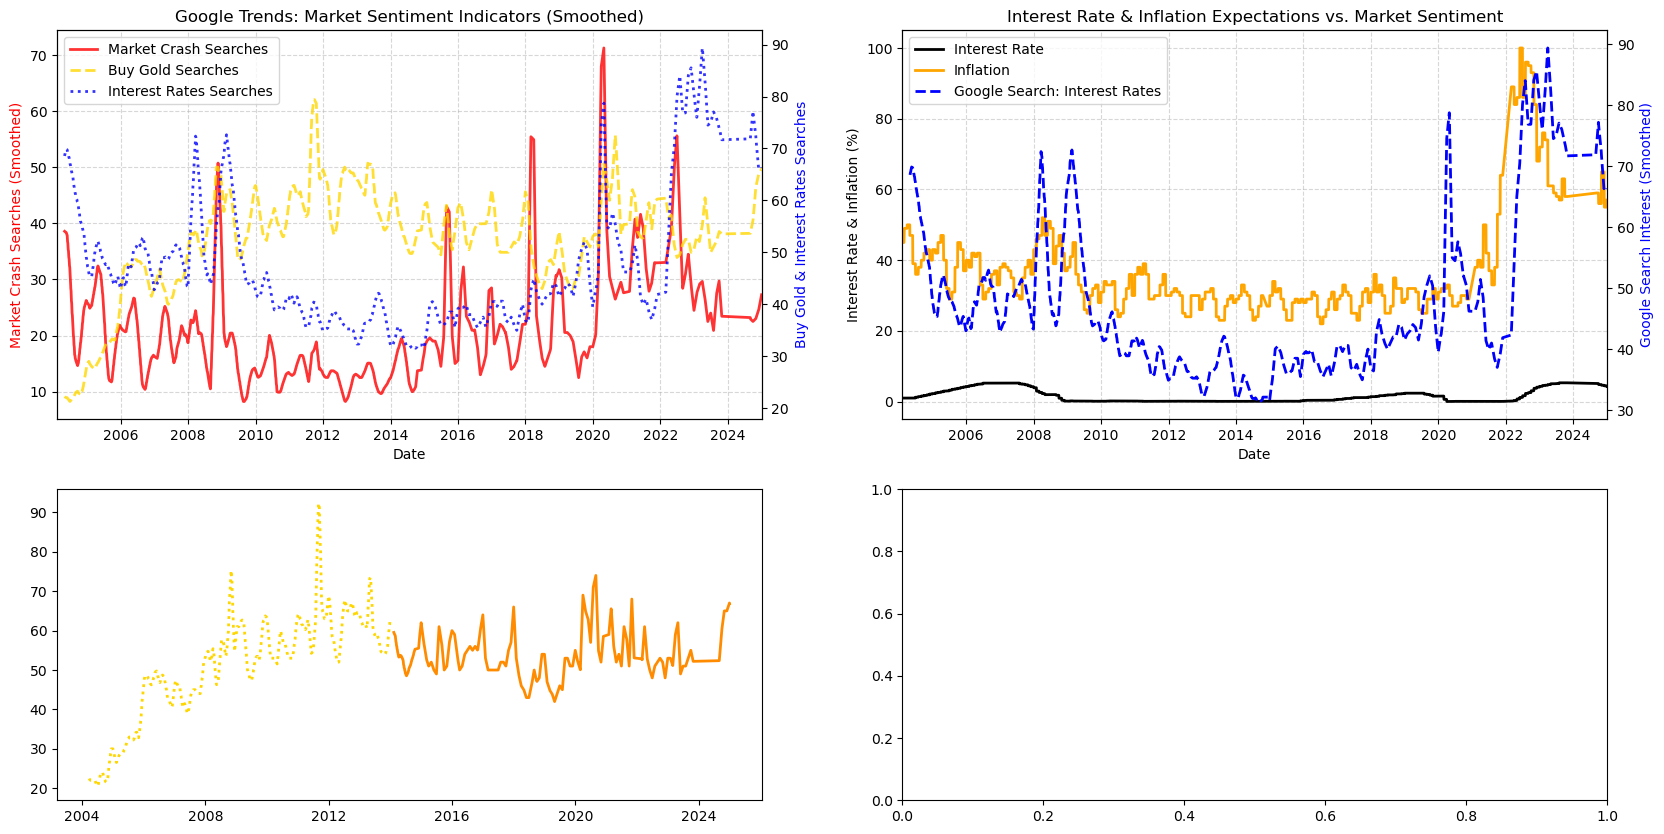

In [ ]:
# Create a multi-panel visualization with 1st row (2 side-by-side) & 2nd row (full width)
fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [1, 0.8]})

### 1️⃣ Google Trends Search Volume Over Time (Smoothed & Improved Layout)
ax1 = axes[0, 0]
ax2 = ax1.twinx()  # Secondary y-axis

# Use 60-day rolling average for smoothing
line1, = ax1.plot(df['Date'], df['market crash'].rolling(60).mean(), 
                   label="Market Crash Searches", color='red', alpha=0.8, linewidth=2, linestyle='-')
line2, = ax2.plot(df['Date'], df['buy gold'].rolling(60).mean(), 
                   label="Buy Gold Searches", color='gold', alpha=0.8, linewidth=2, linestyle='dashed')
line3, = ax2.plot(df['Date'], df['interest rates'].rolling(60).mean(), 
                   label="Interest Rates Searches", color='blue', alpha=0.8, linewidth=2, linestyle='dotted')

ax1.set_xlabel("Date")
ax1.set_ylabel("Market Crash Searches (Smoothed)", color='red')
ax2.set_ylabel("Buy Gold & Interest Rates Searches", color='blue')

ax1.set_title("Google Trends: Market Sentiment Indicators (Smoothed)")
ax1.grid(True, linestyle="--", alpha=0.5)

# ✅ Unified legend placement (Upper Left)
handles = [line1, line2, line3]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left", frameon=True)

### 2️⃣ Interest Rate & Inflation Expectations vs. Market Sentiment (Unified Legend)
ax3 = axes[0, 1]
ax4 = ax3.twinx()

ax3.plot(df['Date'], df['Interest Rate'], label="Interest Rate", color='black', linewidth=2)
ax3.plot(df['Date'], df['inflation'], label="Inflation", color='orange', linewidth=2)
ax4.plot(df['Date'], df['interest rates'].rolling(60).mean(), 
         label="Google Search: Interest Rates", color='blue', linestyle='dashed', linewidth=2)

ax3.set_xlabel("Date")
ax3.set_ylabel("Interest Rate & Inflation (%)", color='black')
ax4.set_ylabel("Google Search Interest (Smoothed)", color='blue')

ax3.set_title("Interest Rate & Inflation Expectations vs. Market Sentiment")
ax3.grid(True, linestyle="--", alpha=0.5)

# ✅ Unified legend placement (Upper Left)
handles1, labels1 = ax3.get_legend_handles_labels()
handles2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(handles1 + handles2, labels1 + labels2, loc="upper left", frameon=True)

# ✅ Extend x-axis for better spacing across first two plots
for ax in [ax1, ax3]:
    ax.set_xlim(df['Date'].min(), df['Date'].max())

# ⚡️ 3️⃣ Bitcoin Era Sentiment Shift (Full-Width, Bottom Row) + 🔥 SIR Model Overlay
ax_btc = axes[1, 0]

# Ensure pre-2014 data exists
pre_btc = df[df['Date'] < '2014-01-01']
post_btc = df[df['Date'] >= '2014-01-01']

# 📈 Plot Search Trends for 'Buy Gold'
ax_btc.plot(pre_btc['Date'], pre_btc['buy gold'].rolling(30).mean(), 
         label="Pre-Bitcoin Era (Before 2014)", color='gold', linestyle='dotted', linewidth=2)

ax_btc.plot(post_btc['Date'], post_btc['buy gold'].rolling(30).mean(), 
         label="Bitcoin Era (2014+)", color='darkorange', linewidth=2)

# 🔴 **Overlay Market Stress Shading**
for _, row in df[df['spike']].iterrows():
    ax_btc.axvspan(row['Date'], row['Date'] + pd.Timedelta(days=60), color='red', alpha=0.2)

# 🟢 **Overlay Market Relief Shading**
ax_btc.fill_between(df['Date'], ax_btc.get_ylim()[0], ax_btc.get_ylim()[1], 
                 where=df['relief_intensity'] > 1, color='green', alpha=0.2)

# 🔥 **NEW: Overlay SIR Model "Infected Traders" (I)**
ax_sir = ax_btc.twinx()
ax_sir.plot(df['Date'], df['I_traders'], label="SIR: Infected Traders", color='red', linestyle='solid', linewidth=2, alpha=0.7)
ax_sir.set_ylabel("Number of Infected Traders (SIR Model)", color="red")

# 📌 Labels and Titles
ax_btc.set_xlabel("Date", fontsize=12)
ax_btc.set_ylabel("Google Search Interest (Smoothed)", fontsize=12, color='black')
ax_btc.set_title("Investor Sentiment Shift & Market Panic Spread (SIR Model)", fontsize=14)

# 🏷️ Improved Legend (Upper Left)
red_patch = mpatches.Patch(color='red', alpha=0.3, label="Market Stress Periods")
green_patch = mpatches.Patch(color='green', alpha=0.3, label="Market Relief Periods")

handles_btc, labels_btc = ax_btc.get_legend_handles_labels()
handles_sir, labels_sir = ax_sir.get_legend_handles_labels()

ax_btc.legend(handles_btc + handles_sir + [red_patch, green_patch], 
              labels_btc + labels_sir + ["Market Stress", "Market Relief"], 
              loc="upper left", frameon=True)

# ✅ Extend x-axis for better spacing across all plots
for ax in [ax1, ax3, ax_btc]:
    ax.set_xlim(df['Date'].min(), df['Date'].max())

# ✅ Remove empty subplot (second column in row 2)
fig.delaxes(axes[1, 1])

# 📊 Improve Grid Visibility
ax_btc.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
df_cleaned.columns

In [ ]:
# import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from scipy.integrate import odeint
from sklearn.preprocessing import MinMaxScaler

# ✅ Load Market Data (df_cleaned)
df = df_cleaned.copy()
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index('Date').sort_index()

# ✅ Step 1: Define Market Stress Indicators
df['Market_Stress'] = df['Adj Close_^VIX'].pct_change().fillna(0)  # Daily VIX % Change
df['Momentum'] = df['Market_Stress'].diff().fillna(0)  # Captures acceleration in stress

# ✅ Step 2: Normalize Beta & Gamma (More Realistic Range)
scaler = MinMaxScaler(feature_range=(0.02, 0.1))  # Slow down Beta
df['Beta'] = scaler.fit_transform(df[['Market_Stress']])  
df['Gamma'] = np.clip(df['Momentum'].abs(), 0.01, 0.05)  # Keep recovery gradual

# ✅ Step 3: Define the SIR Model
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# ✅ Step 4: Initialize Market Participants
N = 100  # Total traders
I0 = 3   # Start with a slightly larger initial reacting trader count
S0 = N - I0  # Initially neutral traders
R0 = 0  # Initially recovered traders

# ✅ Step 5: Run the SIR Model Over Time Using df_cleaned Data
time_steps = len(df)
t = np.linspace(0, time_steps, time_steps)  # Time steps match data length
S, I, R = [], [], []
y0 = [S0/N, I0/N, R0/N]  # Initial conditions

# ✅ Step 6: Solve the SIR Model Iteratively Using Dynamic Beta & Gamma
for i in range(time_steps):
    beta, gamma = df.iloc[i]['Beta'], df.iloc[i]['Gamma']  # Get dynamic beta, gamma
    y0 = odeint(sir_model, y0, [t[i], t[i]+1], args=(beta, gamma))[-1]  # Solve for next step
    S.append(y0[0])
    I.append(y0[1])
    R.append(y0[2])

# ✅ Step 7: Plot the Updated Market Stress SIR Model
plt.figure(figsize=(10, 5))
plt.plot(df.index, S, label="Neutral Traders (S)", color="blue")
plt.plot(df.index, I, label="Reacting Traders (I)", color="red")
plt.plot(df.index, R, label="Adjusted Traders (R)", color="green")
plt.xlabel("Date")
plt.ylabel("Fraction of Traders")
plt.title("Market Stress Spread Using Real Data (SIR Model)")
plt.legend()
plt.show()